In [ ]:
%%javascript
$('.nbp-app-bar').toggle()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from backtest import *
from markethistory import *
import json

In [2]:
print(torch.__version__)

0.4.0


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload

In [22]:
BATCH_SIZE = 128
NUM_FEATURE = 6
NUM_ASSET = 12
OBS_WINDOW = 50

EPISODE_WINDOW = 50

TXN_FEE = 0.0025
SAMPLING_BIAS = 1.9e-3 # This number needs to be carefully chosen.

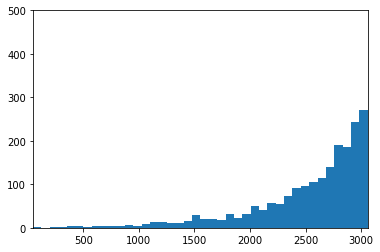

mean:  2522.4385
std:  530.970655703


In [5]:
# Find a good SAMPLING_BIAS

def sample(start, end, bias):
    """
    Geometrically sample a number in [START, END)
    
    Input:
    - start: the start (inclusive)
    - end: the end (exclusive)
    - bias: a number between 0 to 1. The closer the bias to 1, the more
      likely to generate a sample closer to END.
    """
    offset = np.random.geometric(bias)
    return max(end - offset, start)

start, end = 50, 3060 # end is the total time length of training data
data = [sample(start, end, 1.9e-3) for _ in range(2000)]
plt.hist(data, 40)
plt.axis([start, end, 0, 500])
plt.show()
print("mean: ", np.mean(data))
print("std: ", np.std(data))

In [6]:
with open('config.json') as file:
    config = json.load(file)

#### Read price history from database

In [7]:
markethistory = MarketHistory(config)

#### Add constant cash (BTC) price info

In [11]:
data_global = markethistory.data
num_feature, num_asset, T = data_global.shape
btc_price_tensor = np.ones((num_feature, 1, T))
data_global = np.concatenate((btc_price_tensor, data_global), axis=1)
print("Global data tensor shape:", data_global.shape)

Global data tensor shape: (6, 12, 11089)


#### Split data into train, validataion, test

In [12]:
T = data_global.shape[-1]
T_test = int(0.1 * T)
T_valid = int(0.2 * T)
T_train = T - T_test - T_valid

data_global = torch.from_numpy(data_global)
data_train = data_global[:, :, :T_train]
data_valid = data_global[:, :, T_train:T_train+T_valid]
data_test = data_global[:, :, T_train+T_valid:]
print("Training data tensor shape:   ", data_train.shape)
print("Validation data tensor shape: ", data_valid.shape)
print("Testing data tensor shape:    ", data_test.shape)

Training data tensor shape:    torch.Size([6, 12, 7764])
Validation data tensor shape:  torch.Size([6, 12, 2217])
Testing data tensor shape:     torch.Size([6, 12, 1108])


#### Backtest example

In [15]:
policy = DecisionNetwork_CNN()

In [16]:
pm = PortfolioManager(policy)

In [17]:
agent = pm
start_training = "2017/12/15"
end_training = "2018/1/1"
start_testing = "2018/1/15"
end_testing = "2018/2/1"
bt = Backtest(pm,start_training,end_training,start_testing,end_testing)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [ ]:
bt.plot_performance()

#### Define Policy

In [27]:
class PortfolioManager:
    """
    Capsule taking in a trained model to be called by backtest.py.
    get_policy(data) returns a numpy array of shape [T, NUM_ASSET].
    For the first "OBS_WINDOW" observations, allocation is considered to be entirely cash.
    Portfolio manager doesn't trade if recommended allocation for a particular asset is less than a threshold CUTOFF_TRADE.
    """
    def __init__(self,model):
        self.model = model
        
    def get_policy(self,data):
        num_feature, num_asset, T = data.shape
        btc_price_tensor = np.ones((num_feature, 1, T))
        data_global = np.concatenate((btc_price_tensor, data), axis=1)
        data_tensor = torch.from_numpy(data_global)
        allocations = np.zeros((T,num_asset + 1))
        allocations[:OBS_WINDOW,-1] = np.ones(OBS_WINDOW)
        start_w = np.zeros((1,num_asset + 1))
        start_w[:,-1] = 1
        w = torch.from_numpy(start_w)
        for t in range(OBS_WINDOW,T):
            obs = get_observation(np.array([t]),data_tensor)
            obs = obs.type(torch.float32)
            w = self.model.forward(obs,w)
            allocations[t] = w.data.numpy().squeeze()
        self.allocations = allocations
        alloc_without_cash = allocations[:,:-1]
        alloc_without_cash[np.abs(alloc_without_cash) < CUTOFF_TRADE] = 0
        return alloc_without_cash

class DecisionNetwork_CNN(nn.Module):
    """
    An EIIE style decision network implemented with CNN without separate
    cash bias.
    """
    
    def __init__(self):
        super(DecisionNetwork_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=NUM_FEATURE, 
                               out_channels=NUM_FEATURE, 
                               kernel_size=[1,NUM_FEATURE]) # can also use [1,2]
        self.conv2 = nn.Conv2d(in_channels=NUM_FEATURE, 
                               out_channels=20, # can also use 10
                               kernel_size=[1, OBS_WINDOW-2])
        self.conv3 = nn.Conv2d(in_channels=21, 
                               out_channels=1, 
                               kernel_size=[1, 1])
        
    def forward(self, obs, prev_pf_w):
        """
        Compute the forward pass. 
        
        Input:
        - obs: A fresh observation of the market environment at the current time step.
          A tensor of shape [BATCH_SIZE, NUM_FEATURE, NUM_ASSET, OBS_WINDOW].
        - prev_pf_w: The portfolio weight vector in the previous time step. A tensor
          of shape [BATCH_SIZE, NUM_ASSET].
        
        Returns:
        - new_pf_w: The new portfolio weight vector for the current time step. A tensor
          of shape [BATCH_SIZE, NUM_ASSET]
        """
        batch_size, num_features,num_asset,window_length = obs.size()
        scores = nn.ReLU()(self.conv1(obs))
        scores = nn.ReLU()(self.conv2(scores))
        scores = torch.cat([scores, prev_pf_w.view(batch_size, 1, num_asset, 1).float()], dim=1)
        scores = self.conv3(scores).squeeze()
        if batch_size == 1:
            dim = 0
        else:
            dim = 1
        new_pf_w = F.softmax(scores, dim=dim)
        return new_pf_w

#### Define helper functions for training

In [28]:
def sample(start, end, bias):
    """
    Geometrically sample a number in [START, END)
    
    Input:
    - start: the start (inclusive)
    - end: the end (exclusive)
    - bias: a number between 0 to 1. The closer the bias to 1, the more
      likely to generate a sample closer to END.
    """
    offset = np.random.geometric(bias)
    return max(end - offset, start)

def sample_batch(batch_size, start, end, bias):
    """
    Sample a batch of numbers geometrically distributed in [START, END)
    """
    return torch.tensor([sample(start, end, bias) for _ in range(batch_size)])

def get_observation(end_t_batch, history):
    """
    Get a batch of price history of length OBS_WINDOW, ending at END_T_BATCH (inclusive).
    
    Input:
    - end_t_batch: The end time indices of this observation. Shape: [BATCH_SIZE].
    - history: The price history tensor of shape [NUM_FEATURE, NUM_ASSET, T]
    
    Returns:
    - obs: A torch tensor of shape [BATCH_SIZE, NUM_FEATURE, NUM_ASSET, OBS_WINDOW]
    """
    obs = []
    for offset in range(OBS_WINDOW-1, -1, -1):
        t_batch = end_t_batch - offset
        observation = history[:, :, t_batch].permute(2, 0, 1)
        obs.append(observation)
    obs = torch.stack(obs, dim=-1)
    
    # normalize each asset's prices by its lastest closing prices
    last_close_prices = obs[:, 0, :, -1]
    tmp = obs.permute(1, 3, 0, 2) / last_close_prices
    obs = tmp.permute(2, 0, 3, 1)
    
    return obs

def calculate_shrinkage(w, w_prev):
    """
    Calculate the porfolio value shrinkage during a portfolio weight re-allocation due
    to transaction fees.
    This function calculates the shrinkage using an iterative approximation method. See
    equation (14) of the Deep Portfolio Management paper. 
    
    Input:
    - w: Target portfolio weight tensor of shape [BATCH_SIZE, NUM_ASSET]
    - w_prev: Previous portfolio weight tensor of shape [BATCH_SIZE, NUM_ASSET]
    
    Returns:
    - shrinkage: Portfolio value shrinkage multipler tensor of shape [BATCH_SIZE]
    """
    w0_0, w0_m = w_prev[:, 0], w_prev[:, 1:]
    w1_0, w1_m = w[:, 0], w[:, 1:]
    
    const1 = 1 - TXN_FEE * w0_0
    const2 = 2 * TXN_FEE - TXN_FEE ** 2
    const3 = 1 - TXN_FEE * w1_0
    
    u = TXN_FEE * torch.sum(torch.abs(w0_m - w1_m))
    w1_m_T = w1_m.transpose(0, 1)
    while True:
        u_next = (const1 - const2*torch.sum(F.relu(w0_m - (u*w1_m_T).transpose(0,1)), dim=1)) / const3
        max_diff = torch.max(torch.abs(u - u_next))
        if max_diff <= 1e-10:
            return u_next
        u = u_next

#### Define training

In [29]:
# TODO: instaed of fixed window size, try randomized window size
# TODO: modify data matrix so that it includes a row of 1 for Cash
# TODO: think of better way to initialize the initial pf weights

def train(policy, data, lr=1e-3, episodes=10000):
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    T = data.shape[-1]
    
    for i in range(episodes):
        # geometrically sample start times: [batch]
        start_indices = sample_batch(BATCH_SIZE, OBS_WINDOW, T-EPISODE_WINDOW, SAMPLING_BIAS)
        # initialize portfolio weights: [batch, asset]
        pf_w = (torch.ones(NUM_ASSET) / NUM_ASSET).repeat(BATCH_SIZE, 1)
        # initialize portfolio values: [batch]
        pf_v = torch.ones(BATCH_SIZE)
        
        # simulate one episode of live trading with the policy
        loss = 0
        price_curr = data[0, :, start_indices].transpose(0, 1) # [batch, asset]
        for t in range(0, EPISODE_WINDOW):
            price_next = data[0, :, start_indices+t+1].transpose(0, 1) # [batch, asset]
            obs = get_observation(start_indices+t, data)
            
            pf_w_t_start = policy.forward(obs, pf_w)
            shrinkage = calculate_shrinkage(pf_w_t_start, pf_w)
            pf_v_t_start = pf_v * shrinkage
            
            w_tmp = (price_next / price_curr) * pf_w_t_start # [batch, asset]
            w_tmp_sum = torch.sum(w_tmp, dim=1) # [batch]
            pf_v_t_end = w_tmp_sum * pf_v_t_start
            pf_w_t_end = w_tmp / w_tmp_sum.view(BATCH_SIZE, 1)
            
            batch_reward = torch.log(pf_v_t_end / pf_v)
            loss -= torch.sum(batch_reward) / BATCH_SIZE
            
            # update variables
            pf_w = pf_w_t_end
            pf_v = pf_v_t_end
            price_curr = price_next
        loss /= EPISODE_WINDOW
        
        #if i %  == 0:
        print("episode", i, " loss:", float(loss))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# THE REAL DEAL

In [30]:
policy = DecisionNetwork_CNN()

In [33]:
train(policy, data_train, lr=0.1, episodes=1000)

RuntimeError: Expected object of type torch.DoubleTensor but found type torch.FloatTensor for argument #2 'weight'

In [32]:
print(torch.__version__)

0.4.0
